<a href="https://colab.research.google.com/github/ParkJeongUng/Ung.github.io/blob/master/_notebooks/2022-01-28-%EA%B5%90%EC%B0%A8%EA%B2%80%EC%A6%9D%EA%B3%BC_RandomForest_%EB%AA%A8%EB%8D%B8%EC%9D%84_%ED%99%9C%EC%9A%A9%ED%95%9C_%EC%99%80%EC%9D%B8_%ED%92%88%EC%A7%88_%EB%B6%84%EB%A5%98%ED%95%98%EA%B8%B0_(feat_Bayesian_Optimizer)_(3%EC%A3%BC%EC%B0%A8).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 교차검증과 RandomForest 모델을 활용한 와인 품질 분류하기 (feat. Bayesian Optimizer) (3주차)
* 딥러닝 모델로 와인의 품질 예측하기

In [ ]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf
#plt.rc('font', family='NanumGothic') 
#plt.rcParams.update({'font.size' : 11})
plt.rc('figure', facecolor = 'eaeaf2')

import seaborn as sns
def show_countplot(column):
    plt.figure(figsize=(12,4))
    sns.countplot(data=train, x=column).set_title(column)
    plt.show()
    
def show_distplot(column):
    plt.figure(figsize=(12, 4))
    sns.distplot(train[column], bins=50)
    plt.show()

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

## EDA

### EDA 기초
1. 데이터 불러오기
2. 데이터 정보 관측하기
3. 데이터 크기 파악하기
4. 데이터 피쳐 알아보기

In [ ]:
# 데이터 다운로드
!wget 'https://bit.ly/3i4n1QB'

import zipfile
with zipfile.ZipFile('3i4n1QB', 'r') as existing_zip:
    existing_zip.extractall('data')

--2022-01-25 11:42:18--  https://bit.ly/3i4n1QB
Resolving bit.ly (bit.ly)... 67.199.248.10, 67.199.248.11
Connecting to bit.ly (bit.ly)|67.199.248.10|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://drive.google.com/uc?export=download&id=1emLrrpFWT8dCoj5BJb12-5QMG2-nruUw [following]
--2022-01-25 11:42:18--  https://drive.google.com/uc?export=download&id=1emLrrpFWT8dCoj5BJb12-5QMG2-nruUw
Resolving drive.google.com (drive.google.com)... 172.217.9.206, 2607:f8b0:4004:806::200e
Connecting to drive.google.com (drive.google.com)|172.217.9.206|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-10-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/aq9lvj5it6oec0dc1329qqos4m795697/1643110875000/17946651057176172524/*/1emLrrpFWT8dCoj5BJb12-5QMG2-nruUw?e=download [following]
--2022-01-25 11:42:18--  https://doc-10-10-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7

In [ ]:
# 데이터 불러오기
path = '/content/data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
submission = pd.read_csv(path + 'sample_submission.csv')

In [ ]:
# 데이터 정보 관측하기
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5497 entries, 0 to 5496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 5497 non-null   int64  
 1   quality               5497 non-null   int64  
 2   fixed acidity         5497 non-null   float64
 3   volatile acidity      5497 non-null   float64
 4   citric acid           5497 non-null   float64
 5   residual sugar        5497 non-null   float64
 6   chlorides             5497 non-null   float64
 7   free sulfur dioxide   5497 non-null   float64
 8   total sulfur dioxide  5497 non-null   float64
 9   density               5497 non-null   float64
 10  pH                    5497 non-null   float64
 11  sulphates             5497 non-null   float64
 12  alcohol               5497 non-null   float64
 13  type                  5497 non-null   object 
dtypes: float64(11), int64(2), object(1)
memory usage: 601.4+ KB


In [ ]:
# 데이터 크기 파악하기
print('train 크기 : {}'.format(train.shape))
print('test 크기 : {}'. format(test.shape))

train 크기 : (5497, 14)
test 크기 : (1000, 13)


In [ ]:
# 데이터 피쳐 알아보기
train.head().T

,0,1,2,3,4
index,0,1,2,3,4
quality,5,5,5,6,6
fixed acidity,5.6,8.8,7.9,7,7.8
volatile acidity,0.695,0.61,0.21,0.21,0.4
citric acid,0.06,0.14,0.39,0.31,0.26
residual sugar,6.8,2.4,2,6,9.5
chlorides,0.042,0.067,0.057,0.046,0.059
free sulfur dioxide,9,10,21,29,32
total sulfur dioxide,84,42,138,108,178
density,0.99432,0.9969,0.99176,0.9939,0.9955


### 결측치 확인
* info 에서도 확인할 수 있지만 다시한번 확인해보자

In [ ]:
train.isnull().sum()

index                   0
quality                 0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
type                    0
dtype: int64

### 수치데이터 특성보기 (describe())

In [ ]:
train.describe()

,index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,5497.000000,5497.000000,5497.000000,5497.000000,5497.000000,5497.000000,5497.000000,5497.000000,5497.000000,5497.000000,5497.000000,5497.000000,5497.000000
mean,2748.000000,5.818992,7.210115,0.338163,0.318543,5.438075,0.055808,30.417682,115.566491,0.994673,3.219502,0.530524,10.504918
std,1586.991546,0.870311,1.287579,0.163224,0.145104,4.756676,0.034653,17.673881,56.288223,0.003014,0.160713,0.149396,1.194524
min,0.000000,3.000000,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.740000,0.220000,8.000000
25%,1374.000000,5.000000,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,78.000000,0.992300,3.110000,0.430000,9.500000
50%,2748.000000,6.000000,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994800,3.210000,0.510000,10.300000
75%,4122.000000,6.000000,7.700000,0.400000,0.390000,8.100000,0.064000,41.000000,155.000000,0.996930,3.320000,0.600000,11.300000
max,5496.000000,9.000000,15.900000,1.580000,1.660000,65.800000,0.610000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000


### 변수분포 시각화
* matplotlib
* seaborn

In [ ]:
# 라이브러리 임포트
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('figure', facecolor = 'eaeaf2')

In [ ]:
# 시각화 할때는 보통 copy()로 복사본을 생성하고 진행
copy = train.copy()

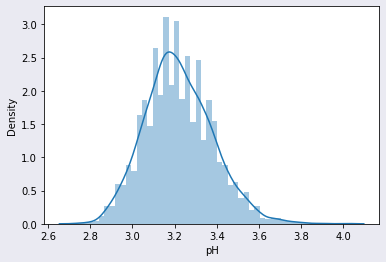

In [ ]:
# seaborn 의 distplot --> 히스토그램
sns.distplot(copy['pH'])

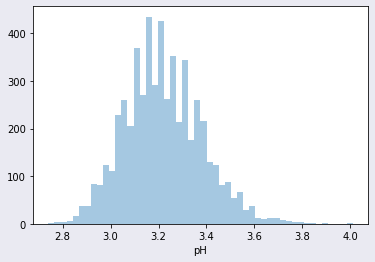

In [ ]:
# kde = False 선 삭제
sns.distplot(copy['pH'], kde = False)

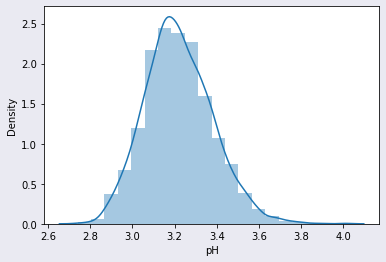

In [ ]:
# bins = 출력할 막대의 갯수를 설정
sns.distplot(copy['pH'], bins = 20)

Text(0.5, 1.0, 'pH histogram')

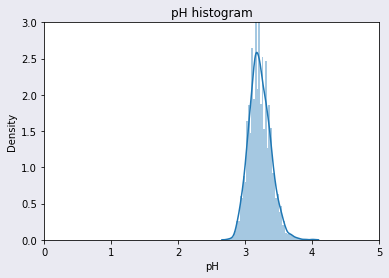

In [ ]:
# plt.axis() 축의 최대 최솟값 지정
# plt.title() 그래프의 제목을 지정
sns.distplot(train['pH'])
plt.axis([0, 5, 0, 3]) # 리스트 형태로 전달해야함
plt.title('pH histogram')

### Matplotlib
* plot // 선
* scatter // 산점도
* hist // 히스토그램

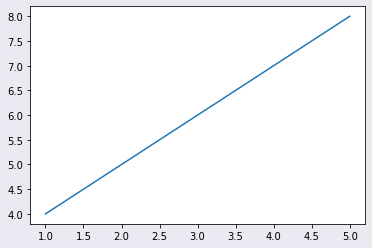

In [ ]:
x = [1,2,3,4,5]
y = [4,5,6,7,8]
plt.plot(x, y)

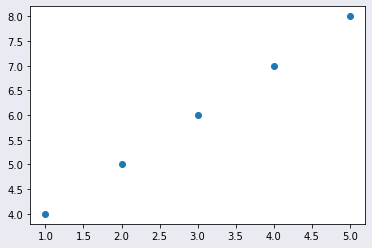

In [ ]:
# 산점도 그래프
plt.scatter(x, y)

(array([  8.,  21., 128., 234., 418., 756., 854., 832., 791., 557., 375.,
        262., 136.,  63.,  34.,  14.,   8.,   2.,   2.,   2.]),
 array([2.74  , 2.8035, 2.867 , 2.9305, 2.994 , 3.0575, 3.121 , 3.1845,
        3.248 , 3.3115, 3.375 , 3.4385, 3.502 , 3.5655, 3.629 , 3.6925,
        3.756 , 3.8195, 3.883 , 3.9465, 4.01  ]),
 <a list of 20 Patch objects>)

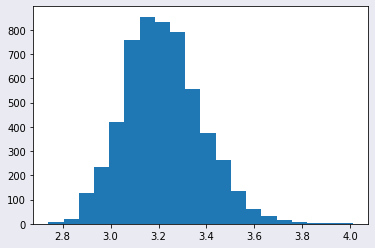

In [ ]:
plt.hist(train['pH'], bins = 20)

## 전처리

### 이상치 탐지
* 이상치 // 일반적인 데이터 패턴과 매우 다른 패턴을 갖는 데이터
* 모델의 성능을 크게 떨어트리기 때문에 제거해줘야 한다
* boxplot을 그려 이상치 찾기
1. 10~8 사이의 실선 : 3분위수 + 1.5 * IQR
2. 파랑색 박스의 위쪽 실선 : 3분위수 (75%)
3. 파랑색 박스의 중앙 실선 : 2분위수 (중앙값)
4. 파랑색 박스의 아래 실선 : 1분위수 (25%)
5. 4~6 사이의 실선 : 1분위수 - 1.5 * IQR
6. 파랑색 박스의 길이 : 3분위수 - 1분위수 = IQR

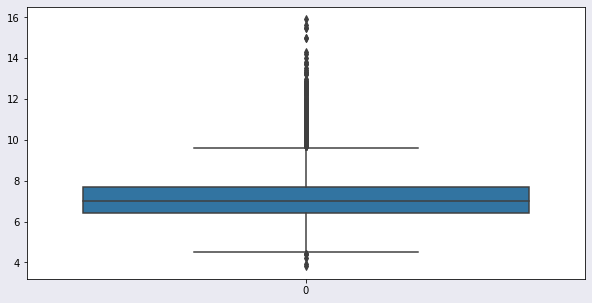

In [ ]:
# boxplot 그리기
fig, axs = plt.subplots(figsize = (10, 5))
sns.boxplot(data = train['fixed acidity'])

### 이상치 제거
* boxplot 실선 범위를 벗어나는 데이터를 이상치로 판단하여 제거
* quantile 함수 // 데이터를 동등한 크기로 분할하는 지점을 지정한다 // ex) 0.25 = 1사분위, 0.5 = 중앙값, 0.75 = 3사분위 

In [ ]:
# 25% 에 위치한 1사분위 값
quantile_25 = np.quantile(train['fixed acidity'], 0.25)

# 75% 에 위치한 3사분위 값
quantile_75 = np.quantile(train['fixed acidity'], 0.75)

# IQR = 박스의 크기 = 3사분위 값 - 1사분위 값
IQR = quantile_75 - quantile_25

print('1사분위 값 : {}\n3사분위 값 : {}\nIQR값 : {}'.format(quantile_25, quantile_75, IQR))

1사분위 값 : 6.4
3사분위 값 : 7.7
IQR값 : 1.2999999999999998


In [ ]:
# boxplot 가장 아래쪽 가로실선 값
minimum = quantile_25 - 1.5 * IQR

# boxplot 가장 위쪽 가로실선 값
maximum = quantile_75 + 1.5 * IQR

# 구한 minimum, maximum 값 사이의 데이터만 출력 
train2 = train[(minimum <= train['fixed acidity']) & (train['fixed acidity'] <= maximum)]

# 294개의 이상치 데이터가 삭제됨
train.shape, train2.shape

((5497, 14), (5203, 14))

### 수치형 데이터 정규화 // Min Max Scailing
* 트리 기반 모델(DecisionTree, RandomForest) 은 대소 비교를 통해 구분하기 때문에 숫자의 단위에 크게 영향을 받지 않는다
* 평활 함수 모델(Linear Regression, Lasso) 은 숫자의 크기와 단위에 양향을 크게 받는다
* 수치형 데이터 정규화를 통해 모든 모델에 잘 어울리는 데이터를 만든다
* Min Max Scailing // 가장 작은 값은 0, 가장 큰 값은 1로 만들고 그 사이의 값들은 비율에 따라 0 ~ 1 사이에 분포하게 만든다


In [ ]:
# describe 로 fixed acidity 데이터 확인
train.describe()['fixed acidity']

count    5497.000000
mean        7.210115
std         1.287579
min         3.800000
25%         6.400000
50%         7.000000
75%         7.700000
max        15.900000
Name: fixed acidity, dtype: float64

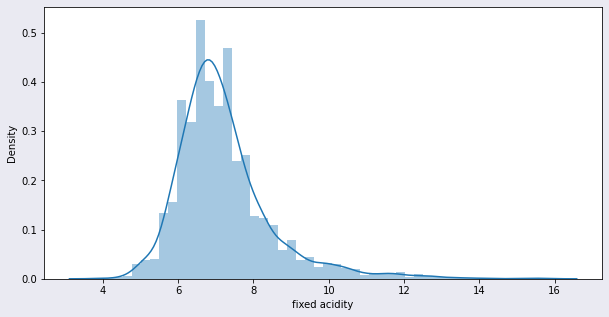

In [ ]:
# seaborn 으로 fixed acidity distplot 그리기
fig, axs = plt.subplots(figsize = (10, 5))
sns.distplot(train['fixed acidity'])

In [ ]:
# MinMaxScaler 임포트
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
# Scaler fit // 스케일러 훈련
scaler.fit(train[['fixed acidity']])

MinMaxScaler()

In [ ]:
# 스케일링 전 값
train[['fixed acidity']]

,fixed acidity
0,5.6
1,8.8
2,7.9
3,7.0
4,7.8
...,...
5492,7.7
5493,6.3
5494,7.8
5495,6.6


In [ ]:
# 스케일링 후 값
train['scaled fixed acidity'] = scaler.transform(train[['fixed acidity']])
train[['scaled fixed acidity']]

,scaled fixed acidity
0,0.148760
1,0.413223
2,0.338843
3,0.264463
4,0.330579
...,...
5492,0.322314
5493,0.206612
5494,0.330579
5495,0.231405


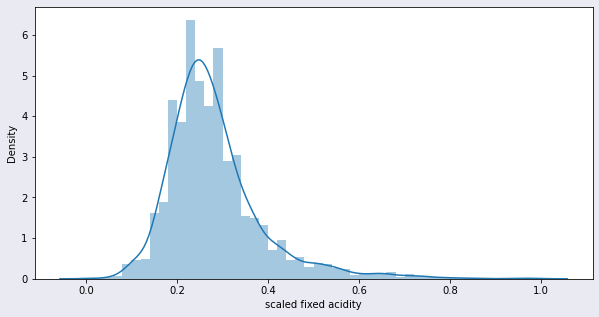

In [ ]:
# 스케일링 한 값으로 distplot 그려보기
fig, axs = plt.subplots(figsize = (10, 5))
sns.distplot(train['scaled fixed acidity'])

In [ ]:
# unique로 데이터의 고유값을 출력
np.sort(train['scaled fixed acidity'].unique())

array([0.        , 0.00826446, 0.03305785, 0.04958678, 0.05785124,
       0.0661157 , 0.07438017, 0.08264463, 0.09090909, 0.09917355,
       0.10743802, 0.11570248, 0.12396694, 0.1322314 , 0.14049587,
       0.14876033, 0.15702479, 0.16528926, 0.17355372, 0.18181818,
       0.19008264, 0.19421488, 0.19834711, 0.20661157, 0.21487603,
       0.21900826, 0.2231405 , 0.23140496, 0.23966942, 0.24793388,
       0.25619835, 0.26446281, 0.27272727, 0.2768595 , 0.28099174,
       0.2892562 , 0.29752066, 0.30578512, 0.31404959, 0.32231405,
       0.33057851, 0.33884298, 0.34710744, 0.3553719 , 0.36363636,
       0.37190083, 0.38016529, 0.38842975, 0.39669421, 0.40495868,
       0.41322314, 0.4214876 , 0.42975207, 0.43801653, 0.44628099,
       0.45454545, 0.46280992, 0.47107438, 0.47933884, 0.48760331,
       0.49586777, 0.50413223, 0.51239669, 0.52066116, 0.52892562,
       0.53719008, 0.54545455, 0.55371901, 0.56198347, 0.57024793,
       0.5785124 , 0.58677686, 0.59504132, 0.60330579, 0.61157

In [ ]:
np.sort(train['fixed acidity'].unique())

array([ 3.8 ,  3.9 ,  4.2 ,  4.4 ,  4.5 ,  4.6 ,  4.7 ,  4.8 ,  4.9 ,
        5.  ,  5.1 ,  5.2 ,  5.3 ,  5.4 ,  5.5 ,  5.6 ,  5.7 ,  5.8 ,
        5.9 ,  6.  ,  6.1 ,  6.15,  6.2 ,  6.3 ,  6.4 ,  6.45,  6.5 ,
        6.6 ,  6.7 ,  6.8 ,  6.9 ,  7.  ,  7.1 ,  7.15,  7.2 ,  7.3 ,
        7.4 ,  7.5 ,  7.6 ,  7.7 ,  7.8 ,  7.9 ,  8.  ,  8.1 ,  8.2 ,
        8.3 ,  8.4 ,  8.5 ,  8.6 ,  8.7 ,  8.8 ,  8.9 ,  9.  ,  9.1 ,
        9.2 ,  9.3 ,  9.4 ,  9.5 ,  9.6 ,  9.7 ,  9.8 ,  9.9 , 10.  ,
       10.1 , 10.2 , 10.3 , 10.4 , 10.5 , 10.6 , 10.7 , 10.8 , 10.9 ,
       11.  , 11.1 , 11.2 , 11.3 , 11.4 , 11.5 , 11.6 , 11.7 , 11.8 ,
       11.9 , 12.  , 12.1 , 12.2 , 12.3 , 12.4 , 12.5 , 12.6 , 12.7 ,
       12.8 , 12.9 , 13.  , 13.2 , 13.3 , 13.4 , 13.5 , 13.7 , 13.8 ,
       14.  , 14.2 , 14.3 , 15.  , 15.5 , 15.6 , 15.9 ])

### 파이썬 인코딩
* 사이킷런 알고리즘은 문자열 값을 입력값으로 허용하지 않는다
* 모든 문자열 값은 인코딩 되어 숫자 형으로 변환해야 한다.

#### 라벨 인코딩 (Label Encoding)
* 카테코리 피쳐를 숫자 값으로 변환한다.
* 숫자 값으로 변환 되었기 때문에 특정 알고리즘에서는 이를 가중치로 인식할 수 있다.
* 트리 계열의 알고리즘을 사용할 때 주로 사용된다.


In [ ]:
from sklearn.preprocessing import LabelEncoder
items=['TV', '냉장고', '전자레인지', '컴퓨터', '선풍기', '믹서', '믹서']
encoder = LabelEncoder()
encoder.fit(items)
label = encoder.transform(items)
label

array([0, 1, 4, 5, 3, 2, 2])

In [ ]:
# 데이터가 작아서 어떤 문자열값이 어떤 숫자값으로 인코딩됐는지 직관적으로 알 수 있지만
# 데이터가 많은 경우에는 classes_ 를 이용해서 확인한다
encoder.classes_

# 처음부터 0, 1 , 2 ... 순서대로

array(['TV', '냉장고', '믹서', '선풍기', '전자레인지', '컴퓨터'], dtype='<U5')

In [ ]:
# inversee_transform 으로 숫자값이 어떤 문자열값이 었는지 확인할 수 있다
print(encoder.inverse_transform([0, 1, 4, 5, 3, 2, 2]))
print(items)

['TV' '냉장고' '전자레인지' '컴퓨터' '선풍기' '믹서' '믹서']
['TV', '냉장고', '전자레인지', '컴퓨터', '선풍기', '믹서', '믹서']


#### 원핫 인코딩 (One-Hot Encoding)
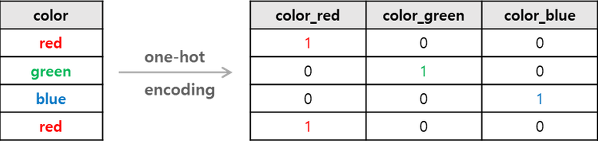

In [ ]:
# 원핫 인코딩은 변환하기 전 모든 문자열 값이 숫자형 값이어야 한다
# 원핫 인코딩은 입력값으로 2차원 데이터가 필요하다
from sklearn.preprocessing import OneHotEncoder
import numpy as np
items=['TV', '냉장고', '전자레인지', '컴퓨터', '선풍기', '믹서', '믹서']

# 숫자형 값으로 변환 (feat.라벨인코딩)
encoder = LabelEncoder()
encoder.fit(items)
label = encoder.transform(items)

# 2차원 데이터로 변환
label = label.reshape(-1, 1)

# 원핫인코딩
encoder = OneHotEncoder()
encoder.fit(label)
label = encoder.transform(label)
print(label.toarray())

[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


In [ ]:
# 판다스에서 get_dummies()를 이용하면 더 쉽게 원핫인코딩이 가능하다
import pandas as pd
items = ['TV', '냉장고', '전자레인지', '컴퓨터', '선풍기', '믹서', '믹서']
df = pd.DataFrame({'item':items})
df

,item
0,TV
1,냉장고
2,전자레인지
3,컴퓨터
4,선풍기
5,믹서
6,믹서


In [ ]:
# get_dummies()
pd.get_dummies(df)

,item_TV,item_냉장고,item_믹서,item_선풍기,item_전자레인지,item_컴퓨터
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,0,0,0,1,0
3,0,0,0,0,0,1
4,0,0,0,1,0,0
5,0,0,1,0,0,0
6,0,0,1,0,0,0


train.head()

#### 데이콘 One-Hot encoding 실습
* 와인이 레드인지 화이트인지 예측하는 문제
* 타겟값인 type 컬럼의 데이터가 white, red로 되어있어서 숫자형으로 변환이 필요

In [ ]:
# 라이브러리 임포트
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

In [ ]:
# 모델 훈련
# 원핫인코딩은 2차원배열 필요
encoder.fit(train[['type']])

OneHotEncoder()

In [ ]:
# 데이터 변환
onehot = encoder.transform(train[['type']])

In [ ]:
# "onehot"이라는 변수를 array 형태로 변환
onehot = onehot.toarray()
onehot

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [ ]:
# "onehot" 변수를 DataFrame 형태로 변환
onehot = pd.DataFrame(onehot)
onehot

,0,1
0,0.0,1.0
1,1.0,0.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
...,...,...
5492,0.0,1.0
5493,0.0,1.0
5494,0.0,1.0
5495,0.0,1.0


In [ ]:
# get_feature_names() // column 이름변경
onehot.columns = encoder.get_feature_names(["type"])
onehot

,type_red,type_white
0,0.0,1.0
1,1.0,0.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
...,...,...
5492,0.0,1.0
5493,0.0,1.0
5494,0.0,1.0
5495,0.0,1.0


In [ ]:
# 원본데이터와 결합 // pd.concat
train = pd.concat([train, onehot], axis = 1)
train.head().T

,0,1,2,3,4
index,0,1,2,3,4
quality,5,5,5,6,6
fixed acidity,5.6,8.8,7.9,7,7.8
volatile acidity,0.695,0.61,0.21,0.21,0.4
citric acid,0.06,0.14,0.39,0.31,0.26
residual sugar,6.8,2.4,2,6,9.5
chlorides,0.042,0.067,0.057,0.046,0.059
free sulfur dioxide,9,10,21,29,32
total sulfur dioxide,84,42,138,108,178
density,0.99432,0.9969,0.99176,0.9939,0.9955


In [ ]:
# type 컬럼 제거
train = train.drop('type', axis = 1)
train.head().T

,0,1,2,3,4
index,0.00000,1.0000,2.00000,3.0000,4.0000
quality,5.00000,5.0000,5.00000,6.0000,6.0000
fixed acidity,5.60000,8.8000,7.90000,7.0000,7.8000
volatile acidity,0.69500,0.6100,0.21000,0.2100,0.4000
citric acid,0.06000,0.1400,0.39000,0.3100,0.2600
residual sugar,6.80000,2.4000,2.00000,6.0000,9.5000
chlorides,0.04200,0.0670,0.05700,0.0460,0.0590
free sulfur dioxide,9.00000,10.0000,21.00000,29.0000,32.0000
total sulfur dioxide,84.00000,42.0000,138.00000,108.0000,178.0000
density,0.99432,0.9969,0.99176,0.9939,0.9955


## 모델링

### 분류 모형 vs 회귀 모형
1. 분류모형 //  Classifier // 어떤 그룹에 속할지를 예측하는 모형
2. 회귀모형 //  Regressor // 집값, 주가, 시가 등등 특정한 값을 맞추는 모형

* 와인이 레드와인인지 화이트와인인지 구분하는 분류문제

### 교차검증 // CrossValidation
* 단순하게 train, test로 분할하면 20% 정도의 데이터는 모델이 학습할 기회도 없이 버려지게됨
* 모든 데이터를 최소한 한 번씩 다 학습하게 하자!


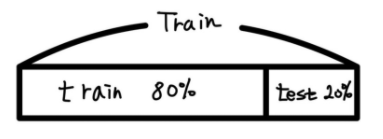

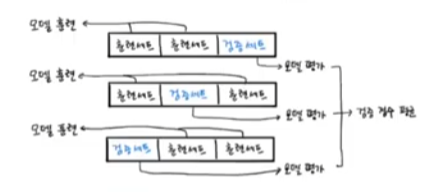

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(train['type'])
train['type'] = encoder.transform(train['type'])

In [ ]:
x_train = train.drop(['index', 'type'], axis = 1)
y_train = train[['type']]

In [ ]:
# cross_validate
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
scores = cross_validate(dt, x_train, y_train)
print(scores) 

# fit_time = 모델 훈련하는데 걸린 시간
# score_time = 모델 검증하는데 걸린 시간
# test_score = 검증 점수

{'fit_time': array([0.02870321, 0.03549719, 0.03126574, 0.03366947, 0.0347476 ]), 'score_time': array([0.00268173, 0.0026443 , 0.00261331, 0.00264478, 0.00260997]), 'test_score': array([0.98181818, 0.98727273, 0.98180164, 0.97907188, 0.98726115])}


In [ ]:
# 검증 점수의 평균
import numpy as np
print(np.mean(scores['test_score']))

0.98344511539416


In [ ]:
# 회귀 모델일 경우 KFold()
# 분류 모델일 경우 StratifiedKFold()

# 분류 모델인 DecisionTreeClassifier 는 StratifiedKFold() 사용
from sklearn.model_selection import StratifiedKFold
scores = cross_validate(dt, x_train, y_train, cv = StratifiedKFold())
print(scores) 

{'fit_time': array([0.03014779, 0.03422737, 0.03189683, 0.03374815, 0.03533077]), 'score_time': array([0.00296164, 0.00312352, 0.00312543, 0.00306916, 0.00301743]), 'test_score': array([0.98181818, 0.99      , 0.98089172, 0.98362147, 0.98908098])}


In [ ]:
# cross_validate() 는 훈련세트를 섞지 않는다 --> shuffle = True
splitter = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42) # n_splits --> 몇폴드 교차검증을 할지 결정 --> 기본은 5폴드
scores = cross_validate(dt, x_train, y_train, cv = splitter)
print(np.mean(scores['test_score'])) 

0.9845368438483192


## 튜닝

### Grid Search vs Random Search vs Bayesian Optimization
1. Grid Search
  * 장점 : 내가 원하는 파라미터 범위를 지정할 수 있다
  * 단점 : 내가 지정한 범위가 성능 최고점이 아닐 가능성이 있다

---
2. Random Search
  * 장점 : 파라미터 범위가 랜덤이니 성능 최고점에 도달할 가능성이 있다
  * 단점 : 오히려 성능이 Grid Search에 비해 안좋아질 수 있다

---
3. Bayesian Optimization
  * 장점 : 결과값에 대한 신뢰도가 높고 "최적의 값"을 찾아갈 수 있다
  * 단점 : Random 하게 탐색하는 횟수인 R번을 잘 지정해주지 않으면 모델 성능이 떨어진다





### Bayesian Optimization
1. 처음 R번은 정말 Random하게 좌표를 꺼내 성능을 확인한다
2. 이후 B번은 Bayesian Optimization을 통해 B번만큼 최적의 값을 찾는다

In [ ]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=4f4d9a3e8d46aac023001f9f6d8276ffe54c9055dadcda9dd3e92586221784de
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [ ]:
# 라이브러리 임포트
from bayes_opt import BayesianOptimization

In [ ]:
# 입력 타겟 분리
X = train.drop(['index', 'quality'], axis = 1)
Y = train['quality']

In [ ]:
# 랜덤포레스트 하이퍼 파라미터 범위를 지정
rf_parameter_bounds = {'max_depth' : (1,3),
                      'n_estimators' : (30, 100)}
rf_parameter_bounds

{'max_depth': (1, 3), 'n_estimators': (30, 100)}

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

def rf_bo(max_depth, n_estimators):
  rf_params = {'max_depth' : int(round(max_depth)),
               'n_estimators' : int(round(n_estimators))}
  rf = RandomForestClassifier(**rf_params) # "**"을 붙이면 딕셔너리형태로 전달한다

  X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size = 0.2)

  rf.fit(X_train, Y_train)
  score = accuracy_score(Y_valid, rf.predict(X_valid)) # 분류모델 기준 정답을 얼마나 맞췄는지 --> accuracy_score
  return score

In [ ]:
# Bayesian Optimization 객체설정
BO_rf = BayesianOptimization(f = rf_bo, pbounds = rf_parameter_bounds, random_state = 0)

# Bayesian Optimization 실행
BO_rf.maximize(init_points = 5, n_iter = 5) # init_points : 처음 랜덤 R번
                                            # n_iter : 반복 횟수(많을 수록 정확한 값을 얻을 수 있다)

|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------
|  1        |  0.5245   |  2.098    |  80.06    |
|  2        |  0.52     |  2.206    |  68.14    |
|  3        |  0.5255   |  1.847    |  75.21    |
|  4        |  0.5055   |  1.875    |  92.42    |
|  5        |  0.5309   |  2.927    |  56.84    |
|  6        |  0.5473   |  2.901    |  48.39    |
|  7        |  0.5464   |  2.351    |  47.63    |
|  8        |  0.5255   |  3.0      |  30.0     |
|  9        |  0.5282   |  3.0      |  41.45    |
|  10       |  0.48     |  1.0      |  50.78    |


In [ ]:
max_params = BO_rf.max['params']
max_params

# 하이퍼 파라미터가 {'max_depth': 2.901408531982906, 'n_estimators': 48.39258528060108} 일때 가장 좋다

{'max_depth': 2.901408531982906, 'n_estimators': 48.39258528060108}